<a href="https://colab.research.google.com/github/astidwis7/speech_matching/blob/main/pySpeechMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Speech Mathcing using Siamese Neural Network***

*The dataset in this program is the audio pronunciation of Hijaiyah letters*

*Link to open the dataset --> [hijaiyahLetters](https://drive.google.com/drive/folders/1YlThJpnb_e_JxEh_QSsCYtq-gtbUUtzl?usp=sharing)*

In [ ]:
# install tensorflow-io

!pip install tensorflow-io

In [ ]:
# retrieve hijaiyah letters audio

import tensorflow as tf
import glob
import numpy as np

!unzip /content/Syi.zip
!unzip /content/Dhi.zip

syi_path = glob.glob('Syi/*.wav')
dhi_path = glob.glob('Dhi/*.wav')

data = []
data_ = []
for _ in syi_path:
  data.append(np.asarray(tf.audio.decode_wav(tf.io.read_file(_)).audio[:44100,:]))
for _ in dhi_path:
  data_.append(np.asarray(tf.audio.decode_wav(tf.io.read_file(_)).audio[:44100,:]))

In [3]:
# audio pairing & labeling

x = []
y = []
for i in range(min([len(data), len(data_)])-1):
  c = []
  c.append(data[i])
  c.append(data[i+1])
  c = np.asarray(c)
  x.append(c)
  y.append(1)

for i in range(min([len(data), len(data_)])-1):
  c = []
  c.append(data[i])
  c.append(data_[i])
  c = np.asarray(c)
  x.append(c)
  y.append(0)

x = np.asarray(x)
y = np.asarray(y).astype('float32')

SNN model initiation

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras import backend as K


def initialize_base_network():
    input = Input(shape=(44100,2,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [5]:
base_network = initialize_base_network()

In [6]:
input_a = Input(shape=(44100,2,), name="left_input")
vect_output_a = base_network(input_a)

input_b = Input(shape=(44100,2,), name="right_input")
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model([input_a, input_b], output)

In [7]:
# function to see the model performance by the  loss

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [8]:
# models training

from tensorflow.keras.optimizers import RMSprop

rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([x[:,0], x[:,1]], y, epochs=20, batch_size=128, validation_data=([x[:,0], x[:,1]], y))

Epoch 1/20
2/2 [==============================] - 3s 1s/step - loss: 1.9805 - val_loss: 2.4999
Epoch 2/20
2/2 [==============================] - 1s 771ms/step - loss: 2.3885 - val_loss: 1.0028
Epoch 3/20
2/2 [==============================] - 1s 734ms/step - loss: 1.1899 - val_loss: 0.5169
Epoch 4/20
2/2 [==============================] - 1s 730ms/step - loss: 0.5903 - val_loss: 0.2301
Epoch 5/20
2/2 [==============================] - 1s 739ms/step - loss: 0.2882 - val_loss: 0.1319
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 0.1842 - val_loss: 0.0940
Epoch 7/20
2/2 [==============================] - 2s 1s/step - loss: 0.1429 - val_loss: 0.0787
Epoch 8/20
2/2 [==============================] - 4s 3s/step - loss: 0.1149 - val_loss: 0.0688
Epoch 9/20
2/2 [==============================] - 3s 2s/step - loss: 0.0932 - val_loss: 0.0552
Epoch 10/20
2/2 [==============================] - 3s 2s/step - loss: 0.0774 - val_loss: 0.0437
Epoch 11/20
2/2 [====================

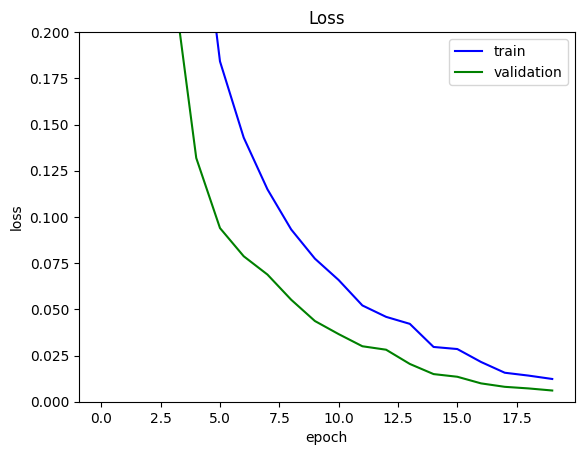

In [9]:
# model training visualization

import matplotlib.pyplot as plt

def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')

plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [10]:
# function to see the model performance by the accuracy

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [11]:
# model testing

loss = model.evaluate(x=[x[:,0],x[:,1]], y=y)

y_pred_train = model.predict([x[:,0], x[:,1]])
train_accuracy = compute_accuracy(y, y_pred_train)

print("Loss = {}, Train Accuracy = {}".format(loss, train_accuracy))

8/8 [==============================] - 1s 54ms/step
Loss = 0.0060673370026052, Train Accuracy = 0.9915966386554622
